In [1]:
import requests
import json
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
linreg = LinearRegression()

def remove_ordinal(dataframe,ordinal_number):
    i=0
    dataframe.reset_index(inplace = True, col_level = 1)
    dataframe['index']=dataframe['index']-ordinal_number
    dataframe.rename(columns={ dataframe.columns[0]: "date" }, inplace = True)
    dataframe.index=dataframe['date']
    dataframe = dataframe.drop(dataframe.columns[0], axis=1)
    return dataframe


#extract dividend data
response = requests.get('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=aapl&outputsize=full&apikey=GZZHIBO1SGTLPGB1')
data = response.text
parsed = json.loads(data)
tsdata = parsed['Time Series (Daily)']
tsda = pd.DataFrame.from_dict(tsdata, orient='index')
tsda_new=tsda.loc[:'2009-01-02',]
tsda_new.index = pd.to_datetime(tsda_new.index)
tsda_new.index=tsda_new.index.map(datetime.datetime.toordinal)

ordinal_for_2009=tsda_new.index[-1]
print(tsda_new)

       1. open   2. high    3. low 4. close 5. adjusted close  6. volume  \
737885  123.87  126.1601    123.07    125.9             125.9   88651175   
737881  123.66    124.18    122.49    123.0             123.0   75089134   
737880  121.65    123.52    121.15   122.15            122.15  118323826   
737879  120.11  120.4031    118.86    119.9             119.9   85671919   
737878  121.65    122.58  120.7299   121.39            121.39   80819203   
...        ...       ...       ...      ...               ...        ...   
733415   90.43     93.15     90.04     92.7      2.8513609598   24053600   
733414   91.81      92.5     90.26    91.01     2.79937821954   26894600   
733413   95.95     97.17     92.39    93.02     2.86120384553   46046800   
733412   93.17     96.18     92.71    94.58     2.90918791346   42200300   
733409   85.88     91.04     85.16    90.75     2.79138087489   26643400   

       7. dividend amount 8. split coefficient  
737885             0.0000             

Text(0.5, 1.0, 'price')

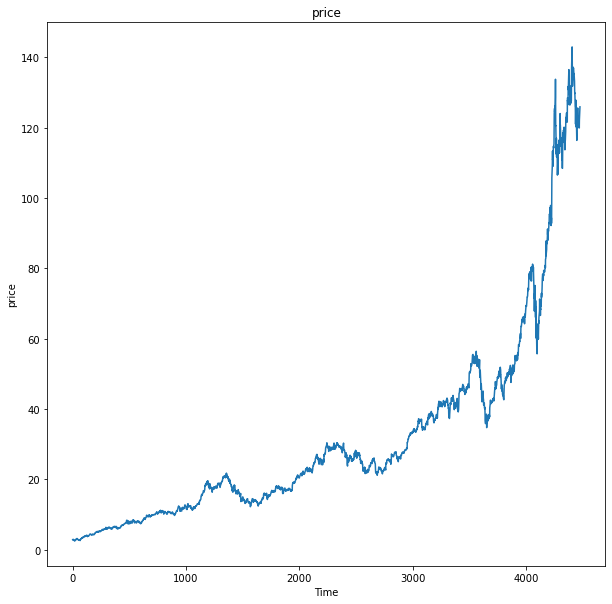

In [2]:
#extracting price
price=tsda_new.drop(['1. open','2. high','3. low','4. close','6. volume','7. dividend amount','8. split coefficient'],1)
price=remove_ordinal(price,ordinal_for_2009)
price.rename(columns={"5. adjusted close":"price"},inplace=True)
price.price = pd.to_numeric(price.price)
price.insert(1, "fed_interest",np.nan)
price.insert(2, "dividend_yield",np.nan)

plt.figure(figsize=(10,10))
plt.plot(price.index, price['price'])
plt.xlabel("Time")
plt.ylabel("price")
plt.title("price")

In [3]:
#extracting dividends
dividend=tsda_new.drop(['1. open','2. high','3. low','5. adjusted close','6. volume','8. split coefficient'],1)

dividend.rename(columns={"4. close":"price","7. dividend amount":"adjusted_dividend"},inplace=True)
#cleaning of dividend data with stock split data
dividend.adjusted_dividend = pd.to_numeric(dividend.adjusted_dividend)
dividend.price = pd.to_numeric(dividend.price)
#remove zeroes
indexNames = dividend[ dividend['adjusted_dividend'] == 0 ].index
dividend.drop(indexNames , inplace=True)
#account for stock split
dividend_before_2020=dividend.loc['2020-08-07':,]
dividend_before_2020=(dividend_before_2020)/4
dividend_before_2014=dividend_before_2020.loc['2014-05-08':,]
dividend_before_2014=dividend_before_2014/7
dividend.update(dividend_before_2020)
dividend.update(dividend_before_2014)
dividend['dividend_yield'] = dividend['adjusted_dividend']/dividend['price']*100


dividend=remove_ordinal(dividend,ordinal_for_2009)
print(dividend)

         price  adjusted_dividend  dividend_yield
date                                             
4417  136.7600              0.205        0.149898
4326  118.6900              0.205        0.172719
4235  444.4500              0.820        0.184498
4144  310.1300              0.820        0.264405
4053  320.0300              0.770        0.240602
3961  259.4300              0.770        0.296805
3871  200.9900              0.770        0.383104
3780  197.1800              0.770        0.390506
3689  170.4100              0.730        0.428379
3597  208.4900              0.730        0.350137
3507  207.5300              0.730        0.351756
3416  188.5900              0.730        0.387083
3325  156.4100              0.630        0.402788
3234  174.6700              0.630        0.360680
3142  155.3200              0.630        0.405614
3051  153.9500              0.630        0.409224
2960  132.4200              0.570        0.430449
2862  109.8300              0.570        0.518984


Text(0.5, 1.0, 'Dividend Yield')

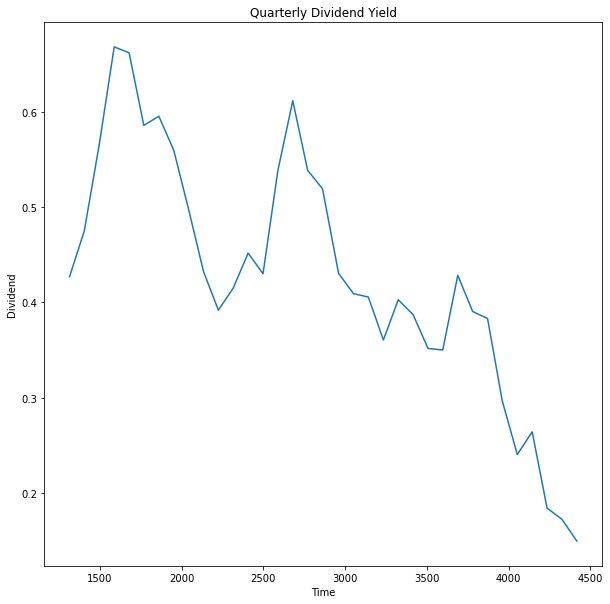

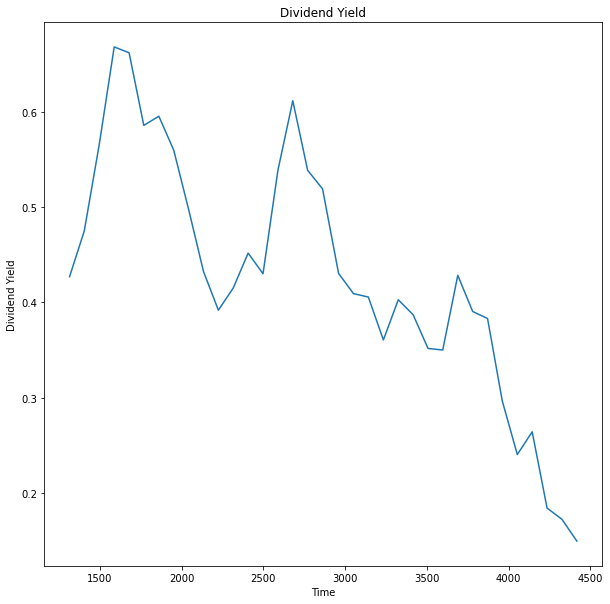

In [4]:

plt.figure(figsize=(10,10))
plt.plot(dividend.index, dividend['dividend_yield'])

plt.xlabel("Time")
plt.ylabel("Dividend")
plt.title("Quarterly Dividend Yield")

plt.figure(figsize=(10,10))
plt.plot(dividend.index, dividend['dividend_yield'])
plt.xlabel("Time")
plt.ylabel("Dividend Yield")
plt.title("Dividend Yield")


In [5]:
#extract interest rates
interest=pd.read_csv('FEDFUNDS.csv',index_col=0)
interest.index = pd.to_datetime(interest.index)
interest.index=interest.index.map(datetime.datetime.toordinal)
interest=remove_ordinal(interest,ordinal_for_2009)
interest = interest.drop(interest.columns[1:], axis=1)
print(interest)

      fed_interest
date              
4490           NaN
4489           NaN
4488           NaN
4487           NaN
4486           NaN
...            ...
4             0.15
3             0.15
2             0.15
1             0.15
0             0.15

[4491 rows x 1 columns]


Text(0.5, 1.0, 'Fed Interest Rates from 2009-2021')

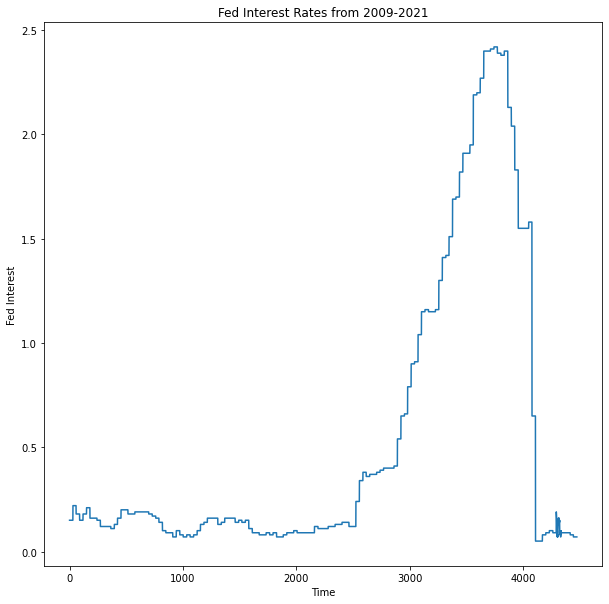

In [6]:
plt.figure(figsize=(10,10))
plt.plot(interest.index, interest['fed_interest'])
plt.xlabel("Time")
plt.ylabel("Fed Interest")
plt.title("Fed Interest Rates from 2009-2021")

Text(0.5, 1.0, 'Quarterly Dividend Yield')

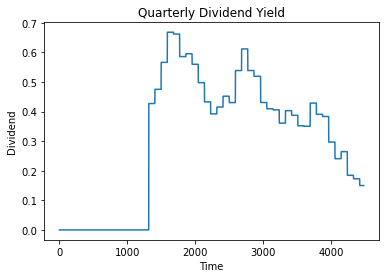

In [7]:
#adding variables to the dataframe
price.update(interest)
price.update(dividend)

#Adding data points
div=0
date=4417
i=price.shape[0]-1
for date in price.index:
    if pd.isnull(price.iloc[i,2]):
        price.iloc[i,2]=div
        i-=1
    else:
        div=price.iloc[i,2]
        i-=1



plt.plot(price.index, price['dividend_yield'])
plt.xlabel("Time")
plt.ylabel("Dividend")
plt.title("Quarterly Dividend Yield")

In [8]:
tsda_new = tsda_new.drop(['1. open','2. high','3. low','4. close','6. volume', '7. dividend amount', '8. split coefficient'],1)
tsda_new.rename(columns={"5. adjusted close":"price"},inplace=True)


In [9]:
tsda_new.price = pd.to_numeric(tsda_new.price)
tsda_new['lnprice'] = np.log(tsda_new['price'])

Text(0.5, 1.0, 'Daily Price')

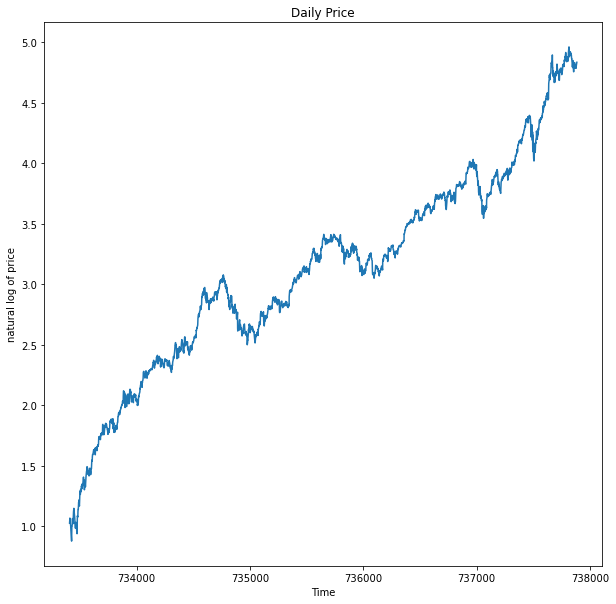

In [10]:
plt.figure(figsize=(10,10))
plt.plot(tsda_new.index, tsda_new['lnprice'])

plt.xlabel("Time")
plt.ylabel("natural log of price")
plt.title("Daily Price")

In [11]:
import seaborn as sb

In [12]:
BALSHT = requests.get('https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol=AAPL&apikey=BNM3OK9KHBBVD3YZ') #api request for balance sheet for AAPL
INCSTAT = requests.get('https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=AAPL&apikey=BNM3OK9KHBBVD3YZ') #api request for income statement for AAPL

bsdata = BALSHT.text
bsparsed = json.loads(bsdata)
bsquartdata = bsparsed['quarterlyReports']
bsquartdf = pd.DataFrame.from_dict(bsquartdata)

isdata = INCSTAT.text
isparsed = json.loads(isdata)
isquartdata = isparsed['quarterlyReports']
isquartdf = pd.DataFrame.from_dict(isquartdata)

In [13]:
bsolddf = pd.read_excel("AAPL BAL SHEET.xls")

isolddf = pd.read_excel("AAPL INCOME SHEET.xls")

In [14]:
assets_liab_new = bsquartdf[['fiscalDateEnding', 'totalAssets', 'totalLiabilities']]
assets_liab_new['fiscalDateEnding'] = pd.to_datetime(assets_liab_new['fiscalDateEnding'])
assets_liab_new[['totalAssets', 'totalLiabilities']] = assets_liab_new[['totalAssets', 'totalLiabilities']].apply(pd.to_numeric)
assets_liab_old = bsolddf[['Period End Date', 'TOTAL ASSETS', 'TOTAL LIABILITIES']]
new_cols = {x: y for x, y in zip(assets_liab_old.columns, assets_liab_new.columns)}
assets_liab1 = assets_liab_new.append(assets_liab_old.rename(columns=new_cols))
assets_liab = assets_liab1.set_index('fiscalDateEnding')
assets_liab

<ipython-input-14-6ed98fd9699b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assets_liab_new['fiscalDateEnding'] = pd.to_datetime(assets_liab_new['fiscalDateEnding'])
D:\Anaconda\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,totalAssets,totalLiabilities
fiscalDateEnding,,
2020-12-31,354054000000,287830000000
2020-09-30,323888000000,258549000000
2020-06-30,317344000000,245062000000
2020-03-31,320400000000,241975000000
2019-12-31,340618000000,251087000000
2019-09-30,338516000000,248028000000
2019-06-30,322239000000,3123000000
2019-03-31,341998000000,3487000000
2018-12-31,373719000000,3819000000


In [15]:
assets_liab.index = pd.to_datetime(assets_liab.index)
assets_liab.index=assets_liab.index.map(datetime.datetime.toordinal)

Text(0.5, 1.0, 'Liaibilities')

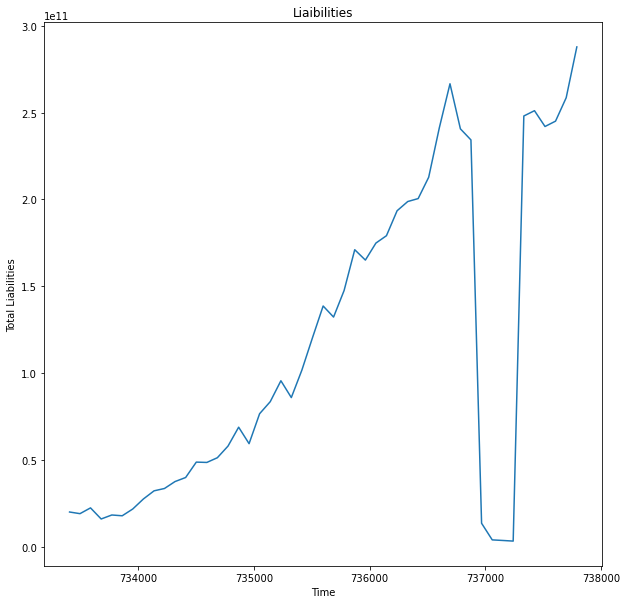

In [27]:
#Just in case the API has errors
assets_liab.loc[737240, 'totalLiabilities'] = 225783000000
assets_liab.loc[737149, 'totalLiabilities'] = 236138000000
assets_liab.loc[737059, 'totalLiabilities'] = 255827000000
assets_liab.loc[736967, 'totalLiabilities'] = 258578000000
assets_liab

,totalAssets,totalLiabilities
fiscalDateEnding,,
737790,354054000000,287830000000
737698,323888000000,258549000000
737606,317344000000,245062000000
737515,320400000000,241975000000
737424,340618000000,251087000000
737332,338516000000,248028000000
737240,322239000000,225783000000
737149,341998000000,236138000000
737059,373719000000,255827000000


Text(0.5, 1.0, 'Liaibilities')

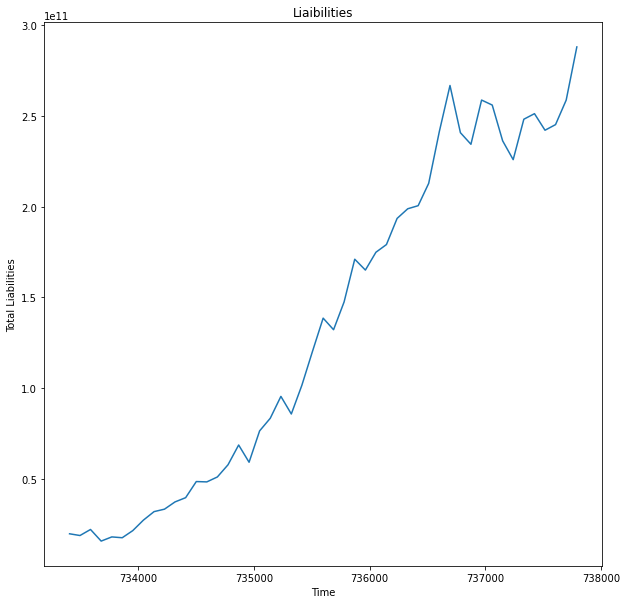

In [28]:
plt.figure(figsize=(10,10))
plt.plot(assets_liab.index, assets_liab['totalLiabilities'])

plt.xlabel("Time")
plt.ylabel("Total Liabilities")
plt.title("Liaibilities")

In [29]:
assets_liab['rolling avg liabilities'] = assets_liab.rolling(window = 5)['totalLiabilities'].mean()

In [31]:
assets_liab['rolling avg liabilities'] = assets_liab['rolling avg liabilities'].apply(lambda x: '{:.0f}'.format(x))
assets_liab

,totalAssets,totalLiabilities,rolling avg liabilities
fiscalDateEnding,,,
737790,354054000000,287830000000,nan
737698,323888000000,258549000000,nan
737606,317344000000,245062000000,nan
737515,320400000000,241975000000,nan
737424,340618000000,251087000000,256900600000
737332,338516000000,248028000000,248940200000
737240,322239000000,225783000000,242387000000
737149,341998000000,236138000000,240602200000
737059,373719000000,255827000000,243372600000


In [42]:
assets_new = assets_liab.loc['737424':]
assets_new

,totalAssets,totalLiabilities,rolling avg liabilities
fiscalDateEnding,,,
737424,340618000000,251087000000,256900600000
737332,338516000000,248028000000,248940200000
737240,322239000000,225783000000,242387000000
737149,341998000000,236138000000,240602200000
737059,373719000000,255827000000,243372600000
736967,365725000000,258578000000,244870800000
736875,349197000000,234248000000,242114800000
736784,367502000000,240624000000,245083000000
736694,406794000000,266595000000,251174400000


Text(0.5, 1.0, 'Liaibilities')

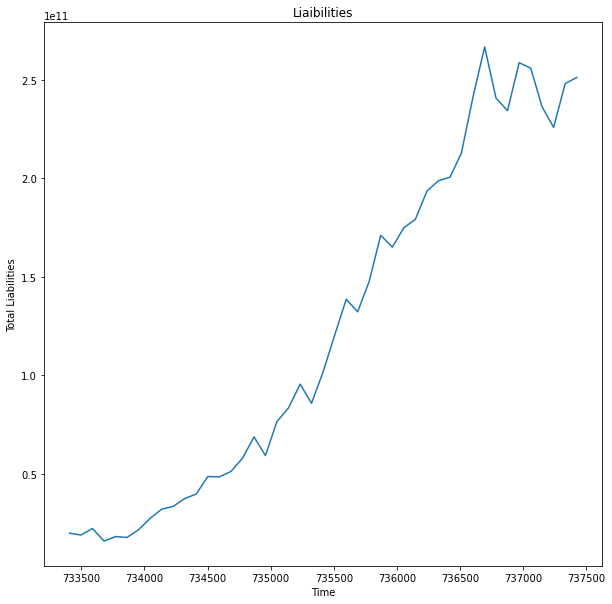

In [43]:
plt.figure(figsize=(10,10))
plt.plot(assets_new.index, assets_new['totalLiabilities'])

plt.xlabel("Time")
plt.ylabel("Total Liabilities")
plt.title("Liaibilities")